# Attention Is All You Need

## Introduction
In This notebook, we will implement the english to german model from the paper titled, "Attention Is All You Need" from scratch in TensorFlow. The structure is as follows:
- Training Data
- Validation Data
- Test Data
- Transformer Model
- Loss
- Learning rate schedule
- Training
- Metrics plot
- Prediction example

__Note__: Keep the paper, "Attention Is All you Need" open for referencing. I will referencing it throughout the notebook.
- Important additional concepts covered: Three-way weight tying, Transformer Architecture, shared Byte-Pair BPE vocabulary.

In [1]:
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Embedding, Dropout, Softmax, Masking
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
import numpy as np
import re
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,CSVLogger,History
import time
import os

2024-08-06 17:47:03.678598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 17:47:03.678750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 17:47:03.850260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#!mkdir /kaggle/working/exp2/

In [3]:
tf.config.list_physical_devices('GPU')

[]

## Training Data 
### Background:
- We are interested WMT 2014 English-German NMT task.
- In the section 5 (Training) of the paper, it mentions:
- - ~ 4.5 million sentence pairs
- - Sentence were encoded using byte-pair encoding.
- - Has shared source-target vocabulary.
- - The vocabulary size is approx 37000.
- - Sentence pairs were batched together by approximate sequence length. Each training
batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000
target tokens.

### Additional details
- I have already provided the prepared training, validation, test data, as well as the vocabulary beforehand. So skip this, if not interested.
- The following steps were done to get exact data as in the paper.
- I will just briefly mention the details for generating the dataset and the vocabulary. If someone needs more detail, then please comment.
- Firstly, download the data from [wmt14](https://www.statmt.org/wmt14/translation-task.html) under the section, 'Download', and the subsection 'parallel-data'. *Europarl v7*, *Common Crawl corpus*, and *News Commentry* options are chosen, and from those zip folders, the corresponding english and german files are used.
- The dev and test set are also present below.
- Next, just adapt the the [script](https://github.com/google/seq2seq/blob/master/bin/data/wmt16_en_de.sh) for wmt2014 and your platform and project structure. Very briefly, this script does the following:
- - Dowloads the zipped training, validation, test data, extracts it, concatenate training data.
- - Clones moses for data preprocessing. Convert between data formats.
- - Tokenise data using moses script.
- - Clean data using moses script.
- - Create BPE vocab using the git [rsennrich/subword-nmt](https://github.com/rsennrich/subword-nmt.git).

__Note:__ The above steps were to obtain exact data as in the paper. Like there are certain implementation details, like preprocessing, the exact way the BPE is generated (BPE algo is ran on the concatentation of english and german training files), etc. For an excellent comprehensive guide, refer to Andrej Karpathy's [excellent video on youtube](https://youtu.be/zduSFxRajkE?si=l5hKj74BB9Zby5gf). 

#### Load Vocabulary

In [4]:
vocabulary = None
pattern = r'\n$'
root = "/kaggle/input/transformer-en-de-nmt-wmt14-bpe/"
with open(root+"vocab.bpe.32000", encoding='utf8') as h:
    vocabulary = h.readlines()
    vocabulary = list(map(lambda word:re.sub(pattern,'', word), vocabulary))
len(vocabulary)

special_tokens = ['<UNK>','<StartOfSequence>','<EndOfSequence>']
total_vocab = vocabulary + special_tokens
len(total_vocab)

36711

#### Create a Dictionary Mapping for the vocabulary

In [5]:
idx   = tf.range(1,len(total_vocab)+1) # start with 1, as 0 is for padding. Has total size of total_vocab
words = total_vocab

idx   = tf.constant(idx)
words = tf.constant(words)

words_idx_init = tf.lookup.KeyValueTensorInitializer(words, idx)
words_idx = tf.lookup.StaticHashTable(words_idx_init,-1)

idx_words_init = tf.lookup.KeyValueTensorInitializer(idx, words)
idx_words = tf.lookup.StaticHashTable(idx_words_init,'<UNK>')

In [6]:
max_seq_len = 64
vocab_size = len(total_vocab)
batch_size=128

#### Data generator

In [7]:
# Training data preprocessing
def preprocess_data(x,y):
   
    
    # Preprocess features
    
    e,d=x
    
    # split sentence
    e= tf.strings.split(tf.strings.join([start,e,end],separator=' ')) 
    
    # tokenize (convert to numbers)
    e = words_idx.lookup(e) 
    
    # Truncate sequence
    e = e[:max_seq_len] 
    
    #padding
    e = tf.concat([e, tf.zeros(max_seq_len-len(e), dtype="int32")],axis=0) 
    
    
    # split sentence
    d = tf.strings.split(tf.strings.join([start,d,end],separator=' ')) 
    
    # tokenize
    d = words_idx.lookup(d) 
    
    # Keep upto max_seq_len token
    d = d[:max_seq_len] 
    
    # Padding
    d = tf.concat([d, tf.zeros(max_seq_len-len(d), dtype="int32")],axis=0) 
    x = (e,d)

    # Preprocess labels
    
    y = tf.strings.split(tf.strings.join([y,end],separator=' '))
    y = words_idx.lookup(y)
    y = y[:max_seq_len]
    y = tf.one_hot(y,len(total_vocab)+1)
    
    #padding
    y = tf.concat([y, tf.zeros((max_seq_len-len(y),len(total_vocab)+1))],axis=0)
    
    
    
    return (x,y)

In [8]:
start = "<StartOfSequence>"
end   = "<EndOfSequence>"


# Dataset object for reading source english corpus (Encoder input)
dataset_en_train = tf.data.TextLineDataset(root+"train.tok.clean.bpe.32000.en")


# Dataset object for reading target german corpus (Decoder Input)
dataset_de_train = tf.data.TextLineDataset(root+"train.tok.clean.bpe.32000.de")

# Zipping the the features sources
train_X = tf.data.Dataset.zip((dataset_en_train,dataset_de_train))

# Dataset object for reading target german corpus (Label)
dataset_label_train = tf.data.TextLineDataset(root+"train.tok.clean.bpe.32000.de")

# Zipping features and labels
train = tf.data.Dataset.zip((train_X,dataset_label_train))

# Shuffle
train=train.shuffle(4700000)# 4462251 sentences in the dataset

# Apply Preprocessing
train=train.map(preprocess_data)

# Batching
train=train.batch(128)
train = train.prefetch(2)

## Validation Data
#### Data generator

In [9]:
start = "<StartOfSequence>"
end   = "<EndOfSequence>"


# Dataset object for reading source english corpus
dataset_en_val = tf.data.TextLineDataset([root+"newstest2012.tok.clean.bpe.32000.en",root+"newstest2013.tok.clean.bpe.32000.en" ])
dataset_en_val = dataset_en_val.map(lambda x: tf.strings.split(tf.strings.join([start,x,end],separator=' ')))
dataset_en_val = dataset_en_val.map(lambda x: words_idx.lookup(x))
dataset_en_val = dataset_en_val.map(lambda x: x[:max_seq_len])
dataset_en_val = dataset_en_val.padded_batch(batch_size,max_seq_len)

# Dataset object for reading target german corpus
dataset_de_val = tf.data.TextLineDataset([root+"newstest2012.tok.clean.bpe.32000.de",root+"newstest2013.tok.clean.bpe.32000.de" ])
dataset_de_val = dataset_de_val.map(lambda x: tf.strings.split(tf.strings.join([start,x,end],separator=' ')))
dataset_de_val = dataset_de_val.map(lambda x: words_idx.lookup(x))
dataset_de_val = dataset_de_val.map(lambda x: x[:max_seq_len])
dataset_de_val = dataset_de_val.padded_batch(batch_size,max_seq_len)


val_X = tf.data.Dataset.zip((dataset_en_val,dataset_de_val))

In [10]:
# Dataset object for reading target german corpus
dataset_label_val = tf.data.TextLineDataset([root+"newstest2012.tok.clean.bpe.32000.de",root+"newstest2013.tok.clean.bpe.32000.de" ])
dataset_label_val = dataset_label_val.map(lambda x: tf.strings.split(tf.strings.join([x,end],separator=' ')))
dataset_label_val = dataset_label_val.map(lambda x: words_idx.lookup(x))
dataset_label_val = dataset_label_val.map(lambda x: x[:max_seq_len]) # -1 because the label doesn't have the start token. I undid this
dataset_label_val = dataset_label_val.map(lambda x: tf.one_hot(x,len(total_vocab)+1)) #  +1 because idx ranges from idx 1 to idx len(total_vocab), but one shot always have index zero to len(total_vocab)
dataset_label_val = dataset_label_val.padded_batch(batch_size,(max_seq_len,len(total_vocab)+1))

In [11]:
val = tf.data.Dataset.zip((val_X,dataset_label_val))

## Test Data
#### Data Generator

In [12]:
start = "<StartOfSequence>"
end   = "<EndOfSequence>"


# Dataset object for reading source english corpus
dataset_en_test = tf.data.TextLineDataset([root+"newstest2014.tok.clean.bpe.32000.en",])
dataset_en_test = dataset_en_test.map(lambda x: tf.strings.split(tf.strings.join([start,x,end],separator=' ')))
dataset_en_test = dataset_en_test.map(lambda x: words_idx.lookup(x))
dataset_en_test = dataset_en_test.map(lambda x: x[:max_seq_len])
dataset_en_test = dataset_en_test.padded_batch(batch_size,max_seq_len)

# Dataset object for reading target german corpus
dataset_de_test = tf.data.TextLineDataset([root+"newstest2014.tok.clean.bpe.32000.de"])
dataset_de_test = dataset_de_test.map(lambda x: tf.strings.split(tf.strings.join([start,x,end],separator=' ')))
dataset_de_test = dataset_de_test.map(lambda x: words_idx.lookup(x))
dataset_de_test = dataset_de_test.map(lambda x: x[:max_seq_len])
dataset_de_test = dataset_de_test.padded_batch(batch_size,max_seq_len)


test_X = tf.data.Dataset.zip((dataset_en_test,dataset_de_test))

In [13]:
# Dataset object for reading target german corpus
dataset_label_test = tf.data.TextLineDataset([root+"newstest2014.tok.clean.bpe.32000.de"])
dataset_label_test = dataset_label_test.map(lambda x: tf.strings.split(tf.strings.join([x,end],separator=' ')))
dataset_label_test = dataset_label_test.map(lambda x: words_idx.lookup(x))
dataset_label_test = dataset_label_test.map(lambda x: x[:max_seq_len]) # -1 because the label doesn't have the start token. I undid this
dataset_label_test = dataset_label_test.map(lambda x: tf.one_hot(x,len(total_vocab)+1)) #  +1 because idx ranges from idx 1 to idx len(total_vocab), but one shot always have index zero to len(total_vocab)
dataset_label_test = dataset_label_test.padded_batch(batch_size,(max_seq_len,len(total_vocab)+1))

In [14]:
test = tf.data.Dataset.zip((test_X,dataset_label_test))

## The Transformer Model

We will be implementing the *base* model.
In table 3 of the paper, in first row, the hyper parameters for the base model are mentioned. We have defined these hyperparameters below as is.

In [15]:
d_model = 512 # 
N = 6 # Number of stacks of Encoders and decoders
h = 8 # parallel attention layers
p_drop = 0.1
dff=2048 # first layer of the FFN

### Scaled Dot-Product Attention
- The details are mentioned in the Figure 2, section 3.2.1, 3.2.3 of the paper.
- I will particularly focus on handling illegal connections and padding.
- I will refer to the image below for the following discussion. $Q$ and $K$ are matrix,$Q$ and $K$ with subscripts are individual queries and entries. Subscript $p$ corresponds to padding token in the matrices $Q$ and $K$.

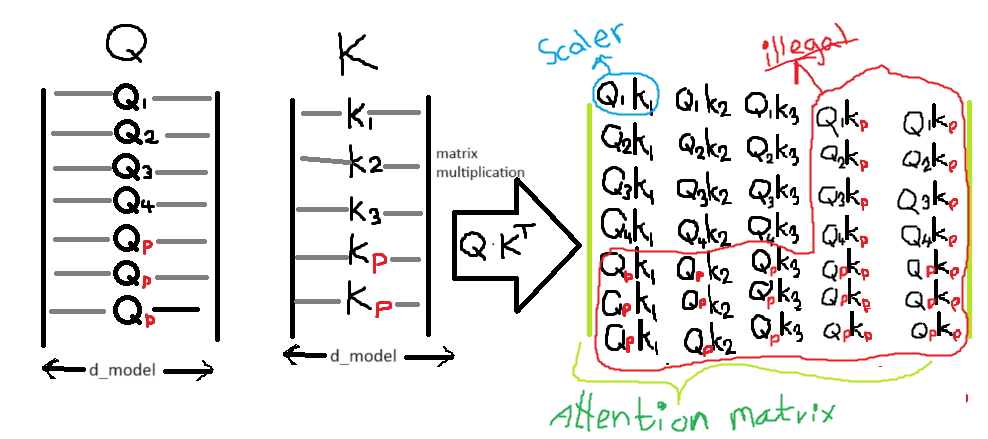
- Matrix $Q$ and $K$ contain queries and keys respectively.
- Each entry of the $Q.K^T$ (Attention matrix) is a dot product between a single query and a key vector.
- Each row of the attention matrix represents the attentions a query pays to all the keys. First rows refers to the attention the first query pays to each key.
- Since queries and keys will be padded, we have to somehow determine the illegal attentions which must be ignored. Here, illegal attentions are the ones involving padding tokens (In red in the above figure). These connections can be determined using the boolean padding masks of $Q$ and $K$.
- In the figure below, we can see how matrix multiplication between masks can be used to determine illegal connections. 1s represent valid attentions.
- __Note:__ We cant just do element-wise multiplication between attention matrix and this mask to zero out illegal attentions, because zero values become non-zero when softmax is applied, which results in query paying attention to illegal connections and therefore illegal padding tokens/values. The paper deals with this (in section 3.2.3) by making these illegal attentions $-\infty$ because it becomes zero after the application of softmax. This what we have done.


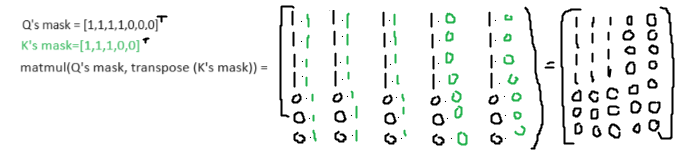

- This layer also needs to handle another mask that arise in the decoder. First, a quick background. This layer is used in self-attention, as well as cross-attention. In self-attention,Q,K,V are same, and the purpose is to determine how much each query in a sequence of queries (Q matrix) pays attention to other queries in the same sequence. In cross-attention, the purpose is to determine, how much attention does the decoder's query pay to each of the tokens in a sequence produced by the encoder.
- Remember, the decoding happens in a autregressive manner, one prediction at time, given the encoder's output and previous prediction upto time step $t-1$, where $t$ is the current time step. So during training, we have to maintain this autoregressive property. When predicting the $i^{th}$ output, which is the same as the (i+1) decoder input, the network mustn't see (i+1)th decoder's input as it will just trivially predict (i+1)th input value. This is enforced as follows.
- In decoder's self attention block, during training, we mask these new illegal attention using the new mask matrix. For a sequence of length seven, this is 7 by 7 matrix with entries above the diagonal being zero. Again this mask is not directly applied to the attention matrix due to softmax issues, but is used in a similar manner to the handling of illegal connections due to padding. The following figure details this:

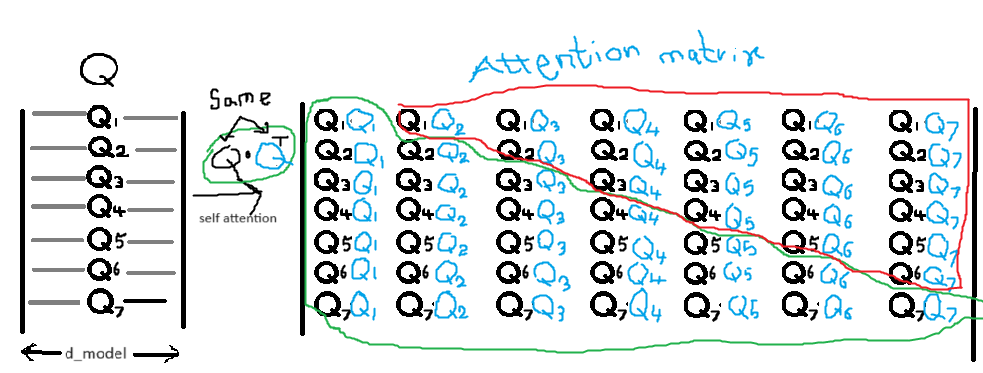
- The red triangle is the illegal connections.
- We create a constant mask as mentioned above. (you'll see this in the Decoder layer below)
- Finally, this autoregressive mask is combines with the padding mask to remove all illegal connections.

In [16]:
class ScaledDotProductAttention(Layer):
    def __init__(self,d_model, num_heads, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)
        self.supports_masking = True
        self.scaling_factor = tf.sqrt(d_model/num_heads)

   
        
    def call(self, Q,K,V, causal_mask=None, mask=None): 
        
    
        key_mask = K._keras_mask
        out = tf.matmul(Q,K, transpose_b=True) # matmul   
        out = tf.divide(out,self.scaling_factor) # scaling

       
        total_mask = None
        # Padding mask will never be none due to embedding layer always passing it  the mask
        mask_Q_num = tf.cast(mask, "float32")
        mask_K_num = tf.cast(key_mask, "float32")
        mask_QK = tf.matmul(mask_Q_num[...,None],mask_K_num[:,None])
        # Mask with illegal connections due to padding. Here, illegal connections are set True value
        illegal_padding_mask = tf.logical_not( tf.cast(mask_QK, dtype=tf.bool) )
        total_mask = illegal_padding_mask
         
    

          
        if causal_mask is not None: # this is bool mask with illegal connections set to True
            total_mask = tf.logical_or(causal_mask[None],total_mask)

        # Setting the illegal connections in the total mask to -infty to make them zero in the softmax computation
        out += tf.cast(total_mask, tf.float32) * tf.float32.min

        out = tf.nn.softmax(out,axis=-1)
        out = out * mask_Q_num[..., None]
        #print(out)
        
        
        out = tf.matmul(out,V)
        return out
            
            

### Multi-Head Attention
- Refer to fig 2 and section 3.2.2 for details.
- This layer creates _h_ linear projections for Q, K, and V. Or _h_ dense layers for each (without bias term)
- Each linear projection projects the _d\_model_ (512 in this case) dimensional tokens in Q,K,and V to _d\_model/h_ dimensional tokens.
- Then it performs _h_ Scaled Dot-product Attention calculations on _h_ tuples of lower dimensional projections of Q, K, and V.
- Then it contenates the _h_ outputs, and performs a final linear operation.

In [17]:
class MultiHeadAttention(Layer):

    """
    Notes: queries, keys, and values will be projected to learned linear projections of 
    dimension d_k, d_k, d_v
    """
    
    def __init__(self,d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__( **kwargs)

        

        
        self.num_heads= num_heads
        self.scaledDotProductAttention = ScaledDotProductAttention(d_model, num_heads)
        
        self.W_Qs = []       # List of Query Weights matrices
        self.W_Ks = []       # List of Key Weights matrices
        self.W_Vs = []       # List of Values Weights matrices
        
        d_k = int(d_model/num_heads) # Projected key dimension
        d_v = d_k                    # Projected value dimension
        
        for i in range(num_heads): 
            self.W_Qs.append(Dense(units = d_k, use_bias=False))
            self.W_Ks.append(Dense(units = d_k, use_bias=False))
            self.W_Vs.append(Dense(units = d_v, use_bias=False))

        self.W_O =  Dense(units = d_model, use_bias=False) 

    def call(self, Q,K,V, causal_mask=None):
        attentionHeads = []
        for i in range(self.num_heads):

            # Project Querys, Keys and Values
            Q_i = self.W_Qs[i](Q) # Queries' Projection for the ith head
            K_i = self.W_Ks[i](K) # Keys' Projection for the ith head
            V_i = self.W_Vs[i](V) # Values' Projection for the ith head
            

            attentionHeads.append(self.scaledDotProductAttention(Q_i,K_i,V_i,causal_mask,mask=Q_i._keras_mask))

        # Concatenate all the attention heads on the last (feature) axis
        concat_heads = tf.concat(attentionHeads,axis=-1)

        # Final linear layer
        return self.W_O(concat_heads)



### FFN
- Refer to section 3.3 of the paper.

In [18]:
class FFN(Layer):
    
    def __init__(self,dff, **kwargs):
        super(FFN, self).__init__()
        self.dense1 =  Dense(units=dff, activation='relu')
        self.dense2 =  Dense(units = d_model)

    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return x

### Residual/Skip connections + Layer Norm
- Refer to Fig 1 and 3.1.

In [19]:
class ResidualBlock(Layer):
    def __init__(self, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.layerNorm = LayerNormalization()
        
    def call(self, sublayer_in, sub_layer_out, mask=None,):
        # masking input before addition. Remember pad values have non-zero vectors
        numeric_mask = tf.cast(mask[...,None],tf.float32)
        masked_in = sublayer_in*numeric_mask
        
        x = tf.add(sub_layer_out, masked_in) 
        x = self.layerNorm(x)
        return x

    

### Sublayer 1 & 2
- Refer to fig 1 and section 3.1.

In [20]:
class SubLayer1(Layer):
    
    def __init__(self, d_model, num_heads, p_drop, **kwargs):
        super(SubLayer1, self).__init__(**kwargs)

        self.supports_masking = True # Because SubLayer2 needs masking     
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.dropout = Dropout(rate=p_drop)
        self.resid = ResidualBlock()

    def call(self, Q,K,V,X, training=False, causal_mask=None, mask=None):
        
        x = self.mha(Q,K,V,causal_mask)
        x = self.dropout(x,training=training)

        x = self.resid(X,x,mask=mask)
        return x
         


In [21]:
class SubLayer2(Layer):
    def __init__(self,dff,p_drop, **kwargs):
        super(SubLayer2, self).__init__(**kwargs)
    
        self.ffn = FFN(dff)
        self.dropout = Dropout(rate=p_drop)
        self.resid = ResidualBlock()
        
    def call(self, X, training=False, mask=None ):
        
        x = self.ffn(X)
        x = self.dropout(x, training=training)

        x = self.resid(X,x,mask=mask)
        return x

### Encoder Layer
- Refer to fig 1.

In [22]:
#### Encoder layer, not encoder
class EncoderLayer(Layer):

    
    def __init__(self, d_model, num_heads, dff, p_drop, **kwargs):
        super(EncoderLayer, self).__init__()
        self.supports_masking = True # for propogation
                        
        self.self_attention = SubLayer1(d_model, num_heads, p_drop)
        self.position_wise = SubLayer2(dff, p_drop)

    def call(self, encoder_input, mask=None, training=False):
        
        #print("encoder layer: " ,mask is not None)
        x = encoder_input
        x = self.self_attention(x,x,x,x,training=training, mask=mask)
        x = self.position_wise(x,training=training, mask=mask)
        return x
    

     

### Positional Embedding
- Refer to section 3.5.

In [23]:
def getPositionalEmbedding(seq_length=256, feature_dimension=None):


    # Returns featrure_dimension dimensional positional encodings for each position in a sequence of length seq_length.
    # return shape (sequ_length, feature_dimension)
    dimensions = tf.range(feature_dimension, dtype=tf.float32)
    positions = tf.range(seq_length, dtype=tf.float32)[...,None] # add additional dimension at the end for broadcasting
    even_dimensions = dimensions[::2]
    odd_dimensions   =  dimensions[1::2]

    feature_dimension = tf.cast(feature_dimension, tf.float32)
    even = tf.sin( positions/tf.pow(10000.,even_dimensions/feature_dimension)  )
    odd  = tf.cos( positions/tf.pow(10000.,odd_dimensions/feature_dimension) )

    # Since for a given position, concatenating the even and odd dimension is functinonally
    # equivalent to interleaving the even and odd dimensions, we will just stack them as follows. (I will later try interleave as well and check the time it takes) 

    sequence_position_embeddings = tf.concat([even,odd], axis=-1)
 
    return sequence_position_embeddings


In [24]:
class PositionalEncoding(Layer):
    """
    This layer takes ouput from the embedding layer. Embedding layer must have output shape of (batch, seq-len, features(d_model))
    """

    def __init__(self, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.supports_masking=True

    def call(self, inputs):
        
        # inputs shape should be (batch, seq-len, features(d_model))
        shape= tf.shape(inputs)
        seq_len, features = shape[1],shape[2]

        positionalEncodings = getPositionalEmbedding(seq_len, features)
        positionalEncodings = positionalEncodings[None,...] # add batch dimension along which to broadcast

        x = tf.add(inputs,positionalEncodings)  # This is equivalent to inputs+positionalEncodings[None]. 
                                                # Here, I explicitly added a batch dimension for broadcasting, but its not needed.
                                                # You can confirm as follows:  print(tf.math.reduce_all((inputs+positionalEncodings[None])==x))
        return x

        


### Decoder Layer 
- Refer to fig 1 and section 3.1.

In [25]:
class DecoderLayer(Layer):
    def __init__(self,d_model, num_heads,dff,p_drop, **kwargs):
        super(DecoderLayer, self).__init__()
        
        self.supports_masking=True # Ensures padding mask's propogation to the next decoder layer.
        self.masked_self_attention = SubLayer1(d_model, num_heads, p_drop) 
        self.encoder_decoder_attention = SubLayer1(d_model, num_heads, p_drop)
        self.position_wise = SubLayer2(dff, p_drop) # Position-wise feed forward

    # Important note: First are should be the tensor whose padding mask needs to be propagated because I chose the easiest way for now.
    def call(self,  decoder_input, encoder_output, causal_mask, mask=None, training=False):
        # tokenEmbeddings: Embeddings of tokens in a sentence
        #self attention, so Q, K, V are all same
        x = decoder_input
        x = self.masked_self_attention(x, x, x, x, causal_mask=causal_mask, mask=mask, training=training)
        x = self.encoder_decoder_attention(x,encoder_output,encoder_output,x, training=training, mask=mask)
        x = self.position_wise(x,training=training, mask=mask)
        return x
     

### Encoder
- Refer to figure 1 and section 3.1.

In [26]:
class Encoder(Layer):
    def __init__(self,N, d_model, num_heads,dff, p_drop, **kwargs):
        super(Encoder, self).__init__(**kwargs)

        self.encoder_layers = []
        for n in range(N):
            self.encoder_layers.append(EncoderLayer(d_model, num_heads,dff, p_drop))
    
    
    def call(self, inputs, training=False):
        x = inputs
        for i,layer in enumerate(self.encoder_layers):
            x = layer(x,training=training) # Each layer recieves masked tensor because the previous layer has self.supports_mask=True
            
        return x 
    


### Decoder
- Refer to Fig 1, section 3.1, 3.2.3.
- Notice, how the causal mask, the one required for maintaing autoregressive property, is created in the constructor.

In [27]:
class Decoder(Layer):
    
    def __init__(self, N, d_model, num_heads, dff, seq_len, p_drop, **kwargs):
        super(Decoder, self).__init__()
        self.decoder_layers = []
        self.causal_mask = tf.constant(np.triu(np.ones((seq_len,seq_len)),k=1 ), dtype=tf.bool)

        for n in range(N):
            self.decoder_layers.append(DecoderLayer(d_model, num_heads,dff, p_drop))

    def call(self, enc_output,  dec_input, training=False):
        #def call(self, encoder_output, decoder_input, mask):
        x = dec_input
        for layer in self.decoder_layers:
            x= layer(x, enc_output,mask=x._keras_mask, causal_mask=self.causal_mask, training=training)
        return x
    

### Embedding scaling
- Refer to section 3.4

In [28]:
class Scaling(Layer):
    # I created this layer, because simply doing a scalar multiplication with
    # a tensor with _keras_mask property resulted in a tensor with no mask.
    def __init__(self, scale, **kwargs):
        super(Scaling,self).__init__(**kwargs)
        self.supports_masking=True
        self.scale=scale
        
    def call(self, inputs):
        return inputs*self.scale
        


### Transformer
- Refer to figure 1, section 3.4, section 5.4 and table 3.
- The important concept here is of weight sharing, or weight tying. The weights of embedding matrix are shared between source, target, and also at the output of the decoder just before the softmax. It is a three-way sharing (or three-way weight tying) of the same weights.

In [29]:
class Transformer(Model):
    def __init__(self, N, d_model, num_heads,dff,seq_len, vocab_size, p_drop, **kwargs):
        super(Transformer,self).__init__(**kwargs)
        self.shared_embedding = Embedding(vocab_size+1,d_model,mask_zero=True) # be becasue word indexes staart from 1, but embedding layer's embedding indexes start from 0.0 index is left for padding
        self.positional_encoding = PositionalEncoding()
        self.encoder = Encoder(N, d_model, num_heads,dff, p_drop)
        self.decoder =  Decoder(N, d_model, num_heads,dff,seq_len, p_drop)
        self.dropout1 = Dropout(p_drop)
        self.dropout2 = Dropout(p_drop)
        self.scale_embed =  Scaling(d_model**.5)

    def call(self, input, training=False):
        """
        enc_inputs : tokenized sequence of shape (batch, enc_seq_len)
        dec_inputs : tokenized sequence of shape (batch, dec_seq_len)
        """

        enc_inputs, dec_inputs = input
        
        enc_inputs = self.shared_embedding(enc_inputs)
        enc_inputs = self.scale_embed(enc_inputs)
        enc_inputs = self.positional_encoding(enc_inputs)  
        enc_inputs = self.dropout1(enc_inputs, training=training)
        
        dec_inputs = self.shared_embedding(dec_inputs)
        dec_inputs = self.scale_embed(dec_inputs)
        dec_inputs = self.positional_encoding(dec_inputs)
        dec_inputs = self.dropout2(dec_inputs, training=training)
        
        enc_output = self.encoder(enc_inputs, training=training)
        decoder_output = self.decoder(enc_output , dec_inputs,training=training) # has shape(batch, dec_input, d_model)

        # Final linear operation. Weight tying
        embed_weights = self.shared_embedding.weights[0] # has shape (vocab_size,d_model)
        embed_weights_scaled = self.scale_embed(embed_weights)

        logits = tf.matmul(decoder_output,embed_weights_scaled,transpose_b=True)

        return logits

## Loss
- Refer to section 5.4 of the paper. The label smoothing part..

In [30]:
loss_obj= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1, reduction='none', from_logits=True)
mask_layer = Masking()

def loss_func(y_true, y_pred):
    
    lab_masked = mask_layer(y_true) # create mask from labels. Read documentation if needed. Basically, if a particular token in a sequence has only zeros in the feature dimension, that token is masked as padding token.
    mask = tf.cast(lab_masked._keras_mask, tf.float32)
    loss = loss_obj(lab_masked[:,:,1:],y_pred[:,:,1:]) # The zeroth index of logits correspond to padding, so ignore it
    masked_loss = loss * mask # zero out the loss values corresponding to padding token vectors.
    
    return tf.reduce_sum(masked_loss)

### Learning rate schedule
- Refer to section 5.3 of the paper.

In [31]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, warmup_steps=4000, d_model=512):
        super(MyLRSchedule,self).__init__()
        self.d_model = d_model#tf.cast(d_model, tf.float32)
        self.warmup_steps=warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        lrate = self.d_model**-.5 * tf.minimum(step**-0.5, step*self.warmup_steps**-1.5)
        return lrate

    
    
    def get_config(self):
        config = {
            'warmup_steps':self.warmup_steps,
            'd_model':self.d_model,
        }
        return config


In [32]:
transformer = Transformer(N, d_model, h,dff,max_seq_len, vocab_size, p_drop)

__Optimizer__
- Refer to section 5.3.

In [33]:
optimizer = tf.keras.optimizers.Adam(beta_1=.9,beta_2=.98,epsilon=10e-9, learning_rate=MyLRSchedule())
transformer.compile(optimizer=optimizer,loss=loss_func)

In [34]:

steps = 7200
epoch='epoch0/'# Change this each epoch
out_path='/kaggle/working/exp2/'+epoch
os.makedirs(out_path)
class CustomCallback(Callback):
    
    
    def on_batch_end(self,batch,logs):

        # Write batch number as well incase we want to resume from where we left of
        path = out_path+"batch.txt"
        f = open(path, "w")
        f.write(str(batch)) 
        f.write("\n")
        f.close()
        
        # Save model
        if (batch+1)%steps==0:# +1 because zero (zeroth) batch is multiple of every number
            #training loss
            path = out_path+'train_loss.txt'
            f = open(path, "a")
            f.write(str(logs["loss"]))
            f.write("\n")
            f.close()

            
            # validation loss
            path = out_path+'val_loss.txt'
            f = open(path, "a")
            val_loss = self.model.evaluate(val)
            f.write(str(val_loss))
            f.write("\n")
            f.close()

            # time
            path = out_path+'time.txt'
            f = open(path, "a")
            f.write(time.strftime("%x %X"))
            f.write("\n")
            f.close()

            # Save model
            self.model.save_weights(root+'model_e_'+ str(round(val_loss,3))+'_.weights.h5')

            
            

    # Since the dataset is not exactly a multiple of steps, we need to consider the loss values when the epoch ends
    def on_epoch_end(self, epochs,logs):
        #training loss
        # validation loss
            path = out_path+'val_loss.txt'
            f = open(path, "a")
            val_loss = self.model.evaluate(val)
            f.write(str(val_loss))
            f.write("\n")
            f.close()

            # time
            path = out_path+'time.txt'
            f = open(path, "a")
            f.write(time.strftime("%x %X"))
            f.write("\n")
            f.close()

            # Save model
            self.model.save_weights(root+'model_e_'+ str(round(val_loss,3))+'_.weights.h5')


In [35]:
transformer = Transformer(N, d_model, h,dff,max_seq_len, vocab_size, p_drop)
optimizer = tf.keras.optimizers.Adam(beta_1=.9,beta_2=.98,epsilon=10e-9, learning_rate=MyLRSchedule())
transformer.compile(optimizer=optimizer,loss=loss_func)

In [36]:
# uncomment to continue training
#history = transformer.fit(train,callbacks=[CustomCallback()])

#### continue training
- epochs 2,3,4,...
- change the epoch folder in the callback each time

In [37]:
transformer = Transformer(N, d_model, h,dff,max_seq_len, vocab_size, p_drop)
optimizer = tf.keras.optimizers.Adam(beta_1=.9,beta_2=.98,epsilon=10e-9, learning_rate=MyLRSchedule())
transformer.compile(optimizer=optimizer,loss=loss_func)

# Uncomment the beloe code to compile and model weights and optimizer's state 

#transformer.fit(train.take(1))# This veryy important!!, otherwise the optimizer;s state is not loaded. The schedule depends on optimizer's state. very important!!
#weights_path = "/kaggle/working/exp2/epoch3/model_e3_20093.691_.weights.h5" # latest weights from the last epoch. Change as per your environment
#transformer.load_weights(weights_path)

In [38]:
transformer.optimizer.iterations.numpy()# Double check if the optimizer's state is loaded correctly. This total number steps the optimizer has taken. Important for schedule

0

- Make sure to update callback code as mentioned above before running the following cell.

In [39]:
# Uncomment to continue training
#history = transformer.fit(train,callbacks=[CustomCallback()])

In [40]:
transformer = Transformer(N, d_model, h,dff,max_seq_len, vocab_size, p_drop)
optimizer = tf.keras.optimizers.Adam(beta_1=.9,beta_2=.98,epsilon=10e-9, learning_rate=MyLRSchedule())
transformer.compile(optimizer=optimizer,loss=loss_func)

# uncomment the below code to load model weights and optimizer's state
#transformer.fit(train.take(1))
#weights_path = "/kaggle/working/model_e3_20364.22"
#transformer.load_weights(weights_path)

In [41]:
transformer.optimizer.iterations.numpy()

0

In [42]:
transformer.summary()

Model: "transformer_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_3           │ ?                      │   0 (unbuilt) │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Encoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Decoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaling_3 (Scaling)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [43]:
#!rm /kaggle/working/model_e3_21717.719_.weights.h5

__Training example output__

In [44]:
sentence_idx = 1
root = "/kaggle/input/transformer-en-de-nmt-wmt14-bpe/"

with open(root+"train.tok.clean.bpe.32000.en",mode="r",encoding="utf8") as f:
    #test_sentence = f.readline()
    #print(f.readline())
    for i in range(sentence_idx):
        test_sentence = f.readline()
    print(test_sentence)
    
with open(root+"train.tok.clean.bpe.32000.de",mode="r",encoding="utf8") as f:
    for i in range(sentence_idx):
        out = f.readline()
    print(out)

Res@@ um@@ ption of the session

Wiederaufnahme der Sitzungsperiode



#### Preprocessing

In [45]:
start = "<StartOfSequence>"
end   = "<EndOfSequence>"

test_sentence = tf.strings.split(tf.strings.join([start,test_sentence,end],separator=' '))
test_sentence

<tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'<StartOfSequence>', b'Res@@', b'um@@', b'ption', b'of', b'the',
       b'session', b'<EndOfSequence>'], dtype=object)>

- Tokenisation

In [46]:
test_sentence =  words_idx.lookup(test_sentence)
test_sentence

<tf.Tensor: shape=(8,), dtype=int32, numpy=
array([36710,  5095,   466, 16678,     5,     3,  5152, 36711],
      dtype=int32)>

- Padding

In [47]:
test_sentence = tf.concat([test_sentence, tf.zeros(max_seq_len-len(test_sentence), dtype="int32")],axis=0)
test_sentence

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([36710,  5095,   466, 16678,     5,     3,  5152, 36711,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)>

In [48]:
### Get output
text= "<StartOfSequence>"
for i in range(max_seq_len):
    # Get padded decoder input

    dec_in = text
    dec_in = tf.strings.split(tf.strings.join([dec_in],separator=' '))
    dec_in =  words_idx.lookup(dec_in)
    dec_in = tf.concat([dec_in, tf.zeros(max_seq_len-len(dec_in), dtype="int32")],axis=0)


    logit = transformer((test_sentence[None],dec_in[None]), training=False)

    word = idx_words.lookup(tf.argmax(tf.nn.softmax(logit[0,i,1:]), output_type="int32")+1).numpy().decode('utf-8')

    text += " " + word
    if word==end:
        break
    

    
    
text     

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'multi_head_attention_54' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'residual_block_90' (of type ResidualBlock) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'ffn_36' (of type FFN) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/con

'<StartOfSequence> Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador'

In [49]:
text.replace("@@ ","") # Checkout rsennrich repo for details

'<StartOfSequence> Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador Salvador'

In [50]:
transformer.evaluate(test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 449s 18s/step - loss: 254079.9219


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


270372.8125

In [51]:
128*64

8192

In [52]:
25000/(128*64)

3.0517578125